In [1]:
!git clone https://github.com/bytedance/UNO.git

Cloning into 'UNO'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 362 (delta 70), reused 72 (delta 61), pack-reused 252 (from 1)
Receiving objects: 100% (362/362), 40.38 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Updating files: 100% (67/67), done.


In [1]:
%cd UNO

/workspace/UNO


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 195.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 174.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 291.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.4/883.4 kB 127.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 244.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 240.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 MB 298.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 288.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 332.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 MB 370.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [3]:
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 51.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 184.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 186.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [4]:
!pip install -e .

Obtaining file:///workspace/UNO
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for uno (pyproject.toml) ... done
  Created wheel for uno: filename=uno-0.0.1-0.editable-py3-none-any.whl size=11961 sha256=b4516a7941b67bbf3b142f59accf0a797d5465064a60d2d23c47141473abcbaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-z_81nmie/wheels/87/eb/d5/7425313a1abad8aac5f330a4fa6e0b7e3c6b4f77fdb9ca045d
Successfully built uno

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
!python -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [6]:
pip install accelerate

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import json
from typing import List, Optional, Union
from PIL import Image
import matplotlib.pyplot as plt

from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

from uno.flux.pipeline import UNOPipeline, preprocess_ref
from accelerate import Accelerator


class UNOProductInterface:
    """
    - Product Photography
    - Logo Add-on
    - Virtual Try-on
    """
    
    def __init__(self, 
                 model_type: str = "flux-dev",
                 device: str = "auto",
                 offload: bool = True,
                 lora_rank: int = 512):
        self.accelerator = Accelerator()
        self.device = self.accelerator.device if device == "auto" else device
        
        print(f"Initializing UNO Pipeline on {self.device}...")
        self.pipeline = UNOPipeline(
            model_type,
            self.device,
            offload,
            only_lora=True,
            lora_rank=lora_rank
        )

        # Default settings
        self.default_settings = {
            'width': 704,
            'height': 704,
            'num_steps': 25,
            'guidance': 4.0,
            'seed': 3407
        }
    
    def _preprocess_images(self, image_paths: Union[str, List[str]], ref_size: int = None) -> List[Image.Image]:

        if isinstance(image_paths, str):
            image_paths = [image_paths]
        
        if ref_size is None:
            ref_size = 512 if len(image_paths) == 1 else 320
        
        ref_imgs = []
        for img_path in image_paths:
            if isinstance(img_path, str):
                img = Image.open(img_path)
            else:  # PIL Image
                img = img_path
            ref_imgs.append(preprocess_ref(img, ref_size))
        
        return ref_imgs
    
    def _display_results(self, generated_image: Image.Image, 
                        ref_images: List[Image.Image], 
                        prompt: str):
        num_refs = len(ref_images)
        fig, axes = plt.subplots(1, num_refs + 1, figsize=(5 * (num_refs + 1), 5))
        
        if num_refs == 0:
            axes = [axes]
        
        # Display reference images
        for i, ref_img in enumerate(ref_images):
            axes[i].imshow(ref_img)
            axes[i].set_title(f"Reference {i+1}")
            axes[i].axis('off')
        
        # Display generated image
        axes[-1].imshow(generated_image)
        axes[-1].set_title("Generated Image")
        axes[-1].axis('off')
        
        plt.suptitle(f"Prompt: {prompt}", fontsize=12, y=0.95)
        plt.tight_layout()
        plt.show()
    
    def product_photography(self, 
                          product_images: Union[str, List[str]], 
                          scene_prompt: str,
                          **kwargs) -> Image.Image:
        """
        Generate product photography by placing products in different scenes
        """
        settings = {**self.default_settings, **kwargs}
        
        ref_imgs = self._preprocess_images(product_images)
        
        print(f"Generating product photography...")
        print(f"Scene: {scene_prompt}")
        print(f"Products: {len(ref_imgs)} item(s)")
        
        generated_image = self.pipeline(
            prompt=scene_prompt,
            width=settings['width'],
            height=settings['height'],
            guidance=settings['guidance'],
            num_steps=settings['num_steps'],
            seed=settings['seed'],
            ref_imgs=ref_imgs,
            pe='d'
        )
        
        self._display_results(generated_image, ref_imgs, scene_prompt)
        return generated_image
    
    def logo_addon(self, 
                   base_objects: Union[str, List[str]],
                   logo_image: str,
                   placement_prompt: str,
                   **kwargs) -> Image.Image:
        """
        Add logo to objects/products
        """
        settings = {**self.default_settings, **kwargs}
        
        all_images = []
        if isinstance(base_objects, str):
            base_objects = [base_objects]
        all_images.extend(base_objects)
        all_images.append(logo_image)
        
        ref_imgs = self._preprocess_images(all_images)
        
        print(f"Adding logo to object(s)...")
        print(f"Placement: {placement_prompt}")
        print(f"Objects: {len(base_objects)} item(s)")
        
        generated_image = self.pipeline(
            prompt=placement_prompt,
            width=settings['width'],
            height=settings['height'],
            guidance=settings['guidance'],
            num_steps=settings['num_steps'],
            seed=settings['seed'],
            ref_imgs=ref_imgs,
            pe='d'
        )
        
        self._display_results(generated_image, ref_imgs, placement_prompt)
        return generated_image
    
    def virtual_tryon(self, 
                     person_image: str,
                     clothing_items: Union[str, List[str]],
                     tryon_prompt: str,
                     **kwargs) -> Image.Image:
        """
        Virtual try-on for clothing/accessories
        """
        settings = {**self.default_settings, **kwargs}
        
        # Combine person and clothing items
        all_images = [person_image]
        if isinstance(clothing_items, str):
            clothing_items = [clothing_items]
        all_images.extend(clothing_items)
        
        ref_imgs = self._preprocess_images(all_images)
        
        print(f"Generating virtual try-on...")
        print(f"Description: {tryon_prompt}")
        print(f"Clothing items: {len(clothing_items)} item(s)")
        
        generated_image = self.pipeline(
            prompt=tryon_prompt,
            width=settings['width'],
            height=settings['height'],
            guidance=settings['guidance'],
            num_steps=settings['num_steps'],
            seed=settings['seed'],
            ref_imgs=ref_imgs,
            pe='d'
        )
        
        self._display_results(generated_image, ref_imgs, tryon_prompt)
        return generated_image
    
    def custom_generation(self,
                         reference_images: Union[str, List[str]],
                         prompt: str,
                         **kwargs) -> Image.Image:
        """
        Custom generation with flexible inputs
        """
        settings = {**self.default_settings, **kwargs}
        
        ref_imgs = self._preprocess_images(reference_images)
        
        print(f"Generating custom image...")
        print(f"Prompt: {prompt}")
        print(f" References: {len(ref_imgs)} item(s)")
        
        generated_image = self.pipeline(
            prompt=prompt,
            width=settings['width'],
            height=settings['height'],
            guidance=settings['guidance'],
            num_steps=settings['num_steps'],
            seed=settings['seed'],
            ref_imgs=ref_imgs,
            pe='d'
        )
        
        self._display_results(generated_image, ref_imgs, prompt)
        return generated_image
  

In [ ]:
from huggingface_hub import login

login(token='token')

In [9]:
uno = UNOProductInterface(
    model_type="flux-dev-fp8",  # Use fp8 for lower memory usage
    offload=True  # Offload for memory efficiency
)

Initializing UNO Pipeline on cuda...


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ae.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Init AE
Init model


flux1-dev.safetensors:   0%|          | 0.00/23.8G [00:00<?, ?B/s]

dit_lora.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

Loading lora
Loading main checkpoint
####
We are in fp8 mode right now, since the fp8 checkpoint of XLabs-AI/flux-dev-fp8 seems broken
we convert the fp8 checkpoint on flight from bf16 checkpoint
If your storage is constrainedyou can save the fp8 checkpoint and replace the bf16 checkpoint by yourself



Generating product photography...
Scene: A cup on a marble desk with soft studio lighting
Products: 1 item(s)


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


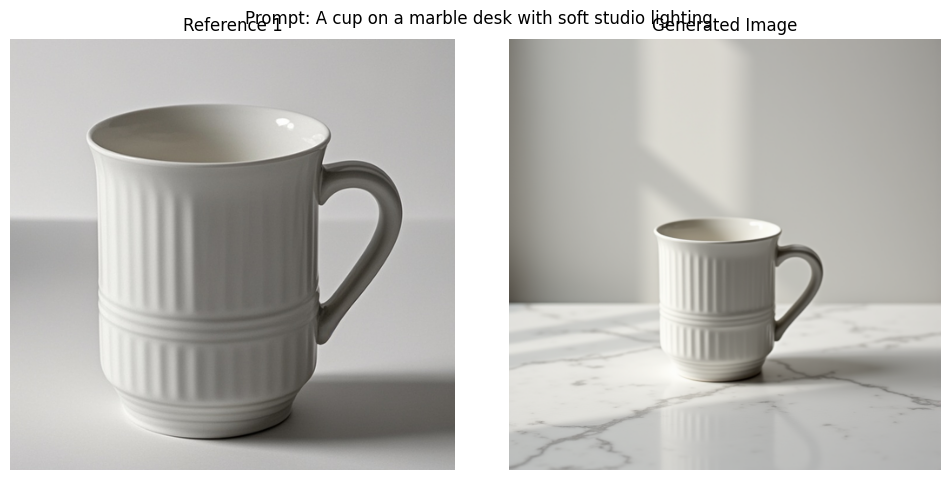

In [10]:
product_photo = uno.product_photography(
    product_images="/workspace/UNO/assets/cup.png",
    scene_prompt="A cup on a marble desk with soft studio lighting",
    width=704,
    height=704
)

Generating product photography...
Scene: A can bottle is placed on a mountain with soft studio lighting
Products: 1 item(s)


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


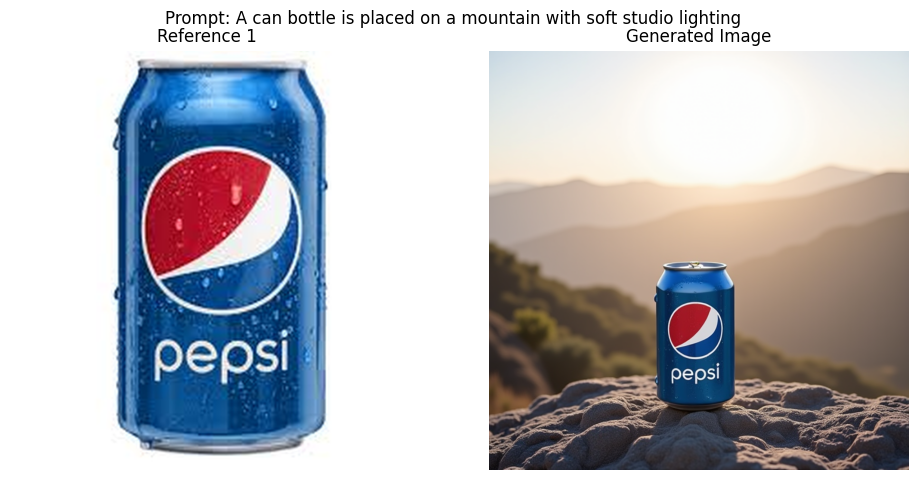

In [11]:
product_photo = uno.product_photography(
    product_images="/workspace/UNO/assets/pepsi.jpg",
    scene_prompt="A can bottle is placed on a mountain with soft studio lighting",
    width=704,
    height=704
)

Generating product photography...
Scene: A can bottle holded by a man in his hand
Products: 1 item(s)


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


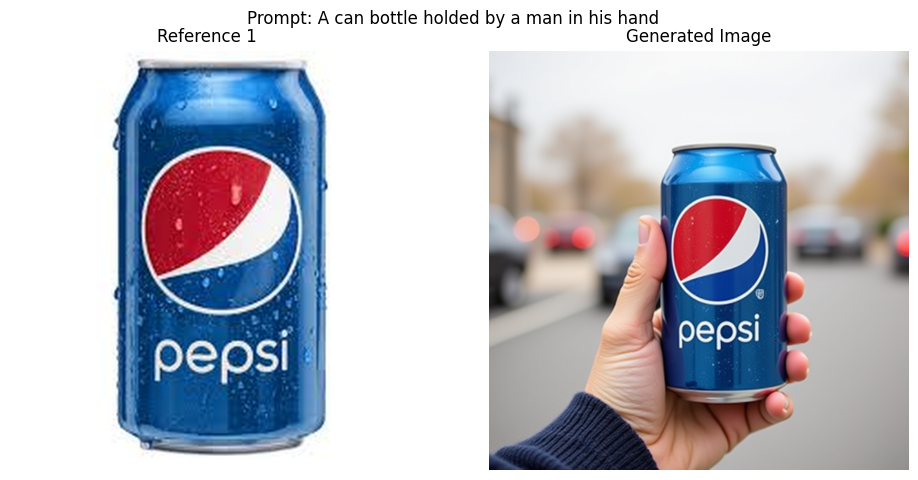

In [12]:
product_photo = uno.product_photography(
    product_images="/workspace/UNO/assets/pepsi.jpg",
    scene_prompt="A can bottle holded by a man in his hand",
    width=704,
    height=704
)

Adding logo to object(s)...
Placement: The logo is printed on the front of the white t shirt
Objects: 1 item(s)


100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


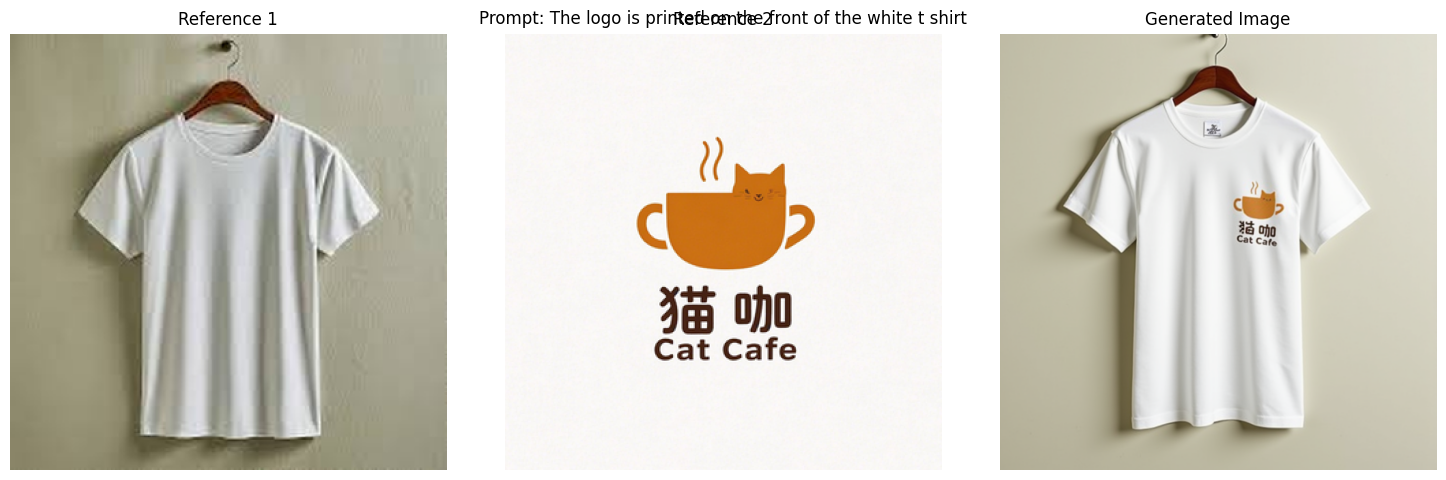

In [18]:
logo_result = uno.logo_addon(
    base_objects="/workspace/UNO/assets/t_shirt.jpg",
    logo_image="/workspace/UNO/assets/cat_cafe.png",
    placement_prompt="The logo is printed on the front of the white t shirt",
    width=704,
    height=704
)

Adding logo to object(s)...
Placement: The clock is printed on the center of the white cup
Objects: 1 item(s)


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


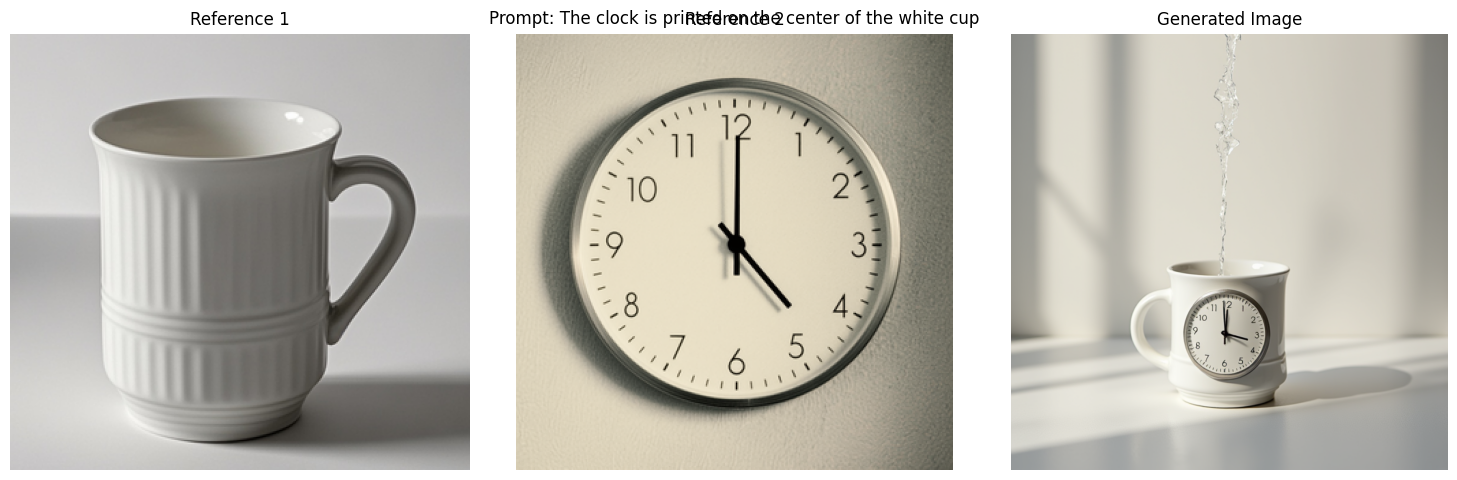

In [16]:
logo_result = uno.logo_addon(
    base_objects="/workspace/UNO/assets/cup.png",
    logo_image="/workspace/UNO/assets/clock.png",
    placement_prompt="The clock is printed on the center of the white cup",
    width=704,
    height=704
)

Generating virtual try-on...
Description: A man wearing the white t shirt
Clothing items: 1 item(s)


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


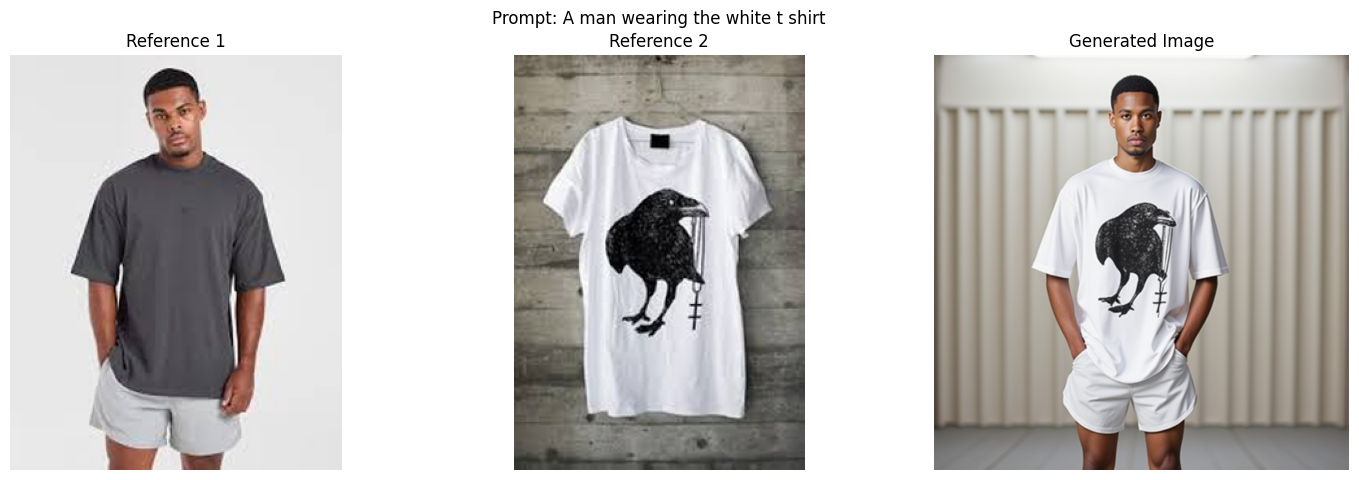

In [20]:
tryon_result = uno.virtual_tryon(
        person_image="/workspace/UNO/assets/person.jpg",
        clothing_items="/workspace/UNO/assets/t_shirt_1.jpg",
        tryon_prompt="A man wearing the white t shirt",
        width=704,
        height=704
    )

In [ ]:
result = uno.custom_generation(
        reference_images="/workspace/UNO/assets/perfume.jpg",
        prompt="professional photogenic view of this perfume for advertisement",
        width=704,
        height=704
    )

Generating custom image...
Prompt: professional photogenic view of this perfume for advertisement
 References: 1 item(s)
